In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Input,MaxPooling2D,Dropout

import os
print(os.listdir("../input"))
style.use('ggplot')
%matplotlib notebook

['dataset']


## Introduction
Create Neural Network Classifier with unsupervised pretraining using 8000 unlabeled and 2000 labeled samples
1. create Autoencoder with unlabled date to create pretrained CNN.
2. use lower layers of Autoencoder to create classifier using only 2000 labeled examples.

In [2]:
base_dir = '../input/dataset/dataset'

#train autoencoder files
train_dir = os.path.join(base_dir,'training_set')

#train classification model files
test_dir = os.path.join(base_dir,'test_set')

train_cats = os.path.join(train_dir,'cats')
train_dogs = os.path.join(train_dir,'dogs')

test_cats = os.path.join(test_dir,'cats')
test_dogs = os.path.join(test_dir,'dogs')

#get filenames
train_cats_fnames = os.listdir(train_cats)
train_dogs_fnames = os.listdir(train_dogs)


(399, 235, 3)
(371, 350, 3)


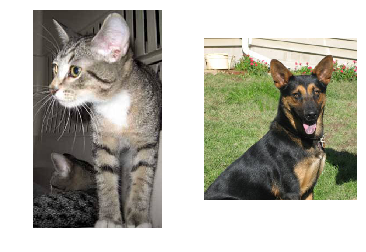

In [3]:
#visualize sample images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

pic = [os.path.join(train_cats, train_cats_fnames[0])]
pic2 = [os.path.join(train_dogs, train_dogs_fnames[0])]

for i, img in enumerate(pic + pic2):
    ax = plt.subplot(1,2,i+1)
    image = mpimg.imread(img)
    ax.axis('off')
    plt.imshow(image)
    print(image.shape)


# Autoencoder 

In [4]:
input_img = Input(shape=(152,152, 3)) #RGB image

#encoder
x = Conv2D(16,(3,3),activation='relu',padding='same',)(input_img)
x = MaxPooling2D(2,padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D(2,padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
encoded = MaxPooling2D(2,padding='same')(x)

# at this point the representation is (19, 19, 8)

#decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder=Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 152, 152, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 152, 152, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 76, 76, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 76, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 8)         0         
__________

In [6]:
# use all data from 'training' directory to train autoencoder

# augment train data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train = ImageDataGenerator(rescale=1./255,
                          rotation_range=40, 
                          width_shift_range=0.2,
                          height_shift_range=0.2, 
                          shear_range=.2)

train_gen = train.flow_from_directory(train_dir,
                                    target_size=(152,152),
                                    batch_size=40,
                                    class_mode=None,
                                   )

Found 8000 images belonging to 2 classes.


In [8]:
# use "test" data to train classification model

test = ImageDataGenerator(rescale=1./255, 
                          validation_split=.4) # split data to train/validation subsets
#train
train_generator = test.flow_from_directory(test_dir,
                                  target_size=(152,152),
                                  batch_size=10,
                                  class_mode='binary',
                                  subset='training'
)
#validation
test_generator = test.flow_from_directory(test_dir,
                                  target_size=(152,152),
                                  batch_size=10,
                                  class_mode='binary',
                                  subset='validation'
)

Found 1200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [9]:
#fit autoencoder model with all training data

def fixed_generator(generator): # autoencoder don't feed labels, but 'fit_generator' need x,y values
    for batch in generator:
        yield (batch, batch)


hist = autoencoder.fit_generator(
    fixed_generator(train_gen),
    epochs = 10,
    steps_per_epoch=200)

Epoch 1/10
200/200 [==============================] - 74s 369ms/step - loss: 24.1828
Epoch 2/10
200/200 [==============================] - 66s 332ms/step - loss: 22.9963
Epoch 3/10
200/200 [==============================] - 66s 331ms/step - loss: 22.7751
Epoch 4/10
200/200 [==============================] - 66s 329ms/step - loss: 22.6818
Epoch 5/10
200/200 [==============================] - 65s 323ms/step - loss: 22.6142
Epoch 6/10
200/200 [==============================] - 65s 325ms/step - loss: 22.5845
Epoch 7/10
200/200 [==============================] - 65s 325ms/step - loss: 22.5189
Epoch 8/10
200/200 [==============================] - 65s 324ms/step - loss: 22.4482
Epoch 9/10
200/200 [==============================] - 64s 322ms/step - loss: 22.3868
Epoch 10/10
200/200 [==============================] - 64s 322ms/step - loss: 22.3399


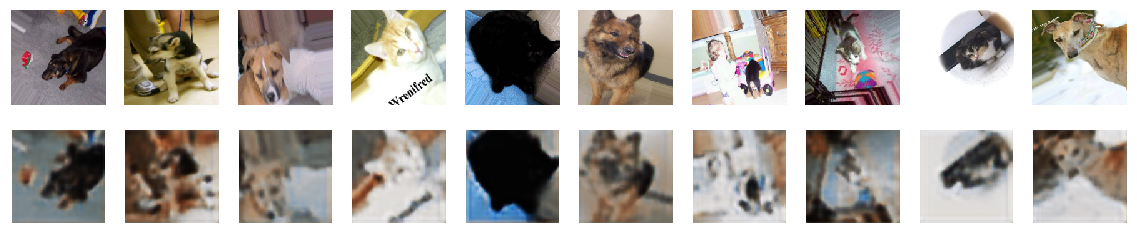

In [10]:
#compare original images with reconstructions

%matplotlib inline
n = 10 # how many samples will be displayed
x = train_gen.next()
decoded_imgs = autoencoder.predict(x)


plt.figure(figsize=(20, 4))
for i in range(n):
#     # display original
    ax = plt.subplot(2, n, i+1)
    image = x[i]
    plt.imshow(image.reshape(152, 152, 3)) #RGB image
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(decoded_imgs[i].reshape(152, 152, 3))#RGB image
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

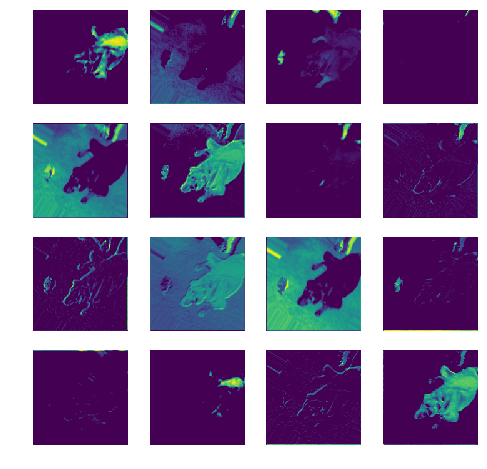

In [11]:
#visualize activations

# to avoid any errors
try:
    layer_outputs = [layer.output for layer in autoencoder.layers[1:2]]
    activation_model = Model(inputs=autoencoder.input, outputs=layer_outputs)
    activations = activation_model.predict(x)
except:
    pass 

n = activations.shape[-1]

fig=plt.figure(figsize=(8, 8))
rows = 4
columns = n//rows
for i in range(n):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(activations[0, :, :, i])
    plt.axis('off')

# classification model

In [12]:
#encoder 
input_img = Input(shape=(152,152, 3)) #RGB image

# use same encoder part
x = Conv2D(16,(3,3),activation='relu',padding='same',)(input_img)
x = MaxPooling2D(2,padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D(2,padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
encoded = MaxPooling2D(2,padding='same')(x)

# add new fully connected layers with output
model = Flatten()(encoded)
model = Dense(1024, activation='elu')(model)
model = keras.layers.BatchNormalization()(model)
model = Dropout(0.5)(model)
model = Dense(1,activation='sigmoid')(model) #output

full_model = Model(input_img, model)

In [13]:
# copy encoder-model weights 

for l1,l2 in zip(full_model.layers[:7],autoencoder.layers[0:7]):
    l1.set_weights(l2.get_weights())

In [14]:
#froze encoder layers to speed up learning time

for layer in full_model.layers[0:7]:
    layer.trainable = False

In [15]:
full_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])

In [16]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 152, 152, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 152, 152, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 76, 76, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 76, 76, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 19, 8)         0         
__________

In [17]:
# add Early Stopping to stop training when a monitored quantity has stopped improving
callbacks =keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=20, 
                                        )

In [18]:
# fit classifier
hist = full_model.fit_generator(train_generator,
                                     epochs=100,
                                     steps_per_epoch=100,
                                     validation_data=test_generator,
                                     validation_steps=100,
                                     callbacks=[callbacks])

Epoch 1/100
100/100 [==============================] - 9s 92ms/step - loss: 1.5633 - acc: 0.5810 - val_loss: 0.8430 - val_acc: 0.6090
Epoch 2/100
100/100 [==============================] - 7s 72ms/step - loss: 0.7411 - acc: 0.6660 - val_loss: 0.7916 - val_acc: 0.5870
Epoch 3/100
100/100 [==============================] - 7s 68ms/step - loss: 0.5705 - acc: 0.7390 - val_loss: 0.8059 - val_acc: 0.6080
Epoch 4/100
100/100 [==============================] - 7s 68ms/step - loss: 0.5315 - acc: 0.7590 - val_loss: 0.8325 - val_acc: 0.6120
Epoch 5/100
100/100 [==============================] - 7s 67ms/step - loss: 0.5114 - acc: 0.7610 - val_loss: 0.9021 - val_acc: 0.5880
Epoch 6/100
100/100 [==============================] - 7s 67ms/step - loss: 0.4560 - acc: 0.7880 - val_loss: 0.8049 - val_acc: 0.6130
Epoch 7/100
100/100 [==============================] - 7s 68ms/step - loss: 0.3898 - acc: 0.8220 - val_loss: 0.8456 - val_acc: 0.6130
Epoch 8/100
100/100 [==============================] - 7s 68ms

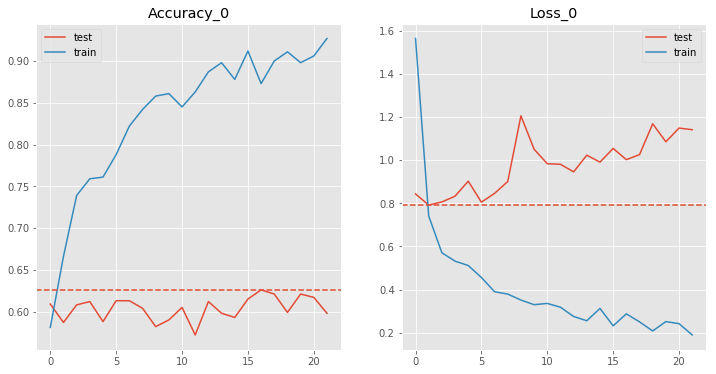

In [19]:
# visualize results

from matplotlib import style
# style.use('dark_background')
%matplotlib inline
def show_results(hists):
    for i,hist in enumerate(hists):
        plt.figure(figsize=(12,6))
        plt.subplot(len(hists),2,1)
        acc = hist.history['acc']
        test_acc = hist.history['val_acc']
        loss=hist.history['loss']
        test_loss=hist.history['val_loss']
        epochs=range(len(acc))
        plt.plot(epochs,test_acc,label='test')
        plt.plot(epochs,acc,label='train')
        plt.axhline(y=max(test_acc), linestyle='--')
        plt.legend()
        plt.title('Accuracy_{}'.format(i))
        plt.subplot(len(hists),2,2)
        plt.plot(epochs,test_loss,label='test')
        plt.plot(epochs,loss,label='train')
        plt.axhline(y=min(test_loss),linestyle='--')
        plt.legend()
        plt.title('Loss_{}'.format(i))
show_results([hist])

## summary
Above model is overtrained and but still got ≈ 60% accuracy with only 1200 training and 800 validation samples!